In [3]:
# INTERACTIVE PLOTS (only if you code locally, unfortunately)
# This cell can take some minutes to run
# You should only need to run this cell once and not everytime you open the script
# In case the plotting of the data below does not work because of the error "Error displaying widget: model not found"
# you'll probably have to restart your kernel once more.

# IMPORTANT: After running this cell, restart your kernel
# uncomment the next two lines for interactive plots
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet
# !pip install install nodejs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import os
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.integrate import cumtrapz
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import find_peaks
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np 
import heapq
from joblib import load 

from xgboost import XGBClassifier



# You may change the mhealth_activity module but your algorithm must support the original version
from mhealth_activity import Recording, Trace, Activity, WatchLocation, Path

# For interactive plots, uncomment the following line
# %matplotlib widget

In [8]:
#Split all test data into uphill and downhill

#save all test data into a list

'''all_test_data = []
for i in range(0, 280):
    all_test_data.append(Recording(f'data/test/test_trace_{i:03d}.pkl'))
'''
all_train_data = []
for i in range(0, 395):
    train_data.append(Recording(f'data/train/train_trace_{i:03d}.pkl'))


'''#compare altitude of the average of the first 100 and last 100 points
uphill_train = []
downhill_train = []
for recording in train_data:
    if np.mean(recording.data['altitude'].values[:100]) < np.mean(recording.data['altitude'].values[-100:]):
        uphill_train.append(recording)
    else:
        downhill_train.append(recording)

# delete traces with path label 3 and 4 in uphill_train

uphill_train = [recording for recording in uphill_train if recording.labels['path_idx'] not in [3, 4]]

# delete traces with path label 0, 1 and 2 in downhill_train

downhill_train = [recording for recording in downhill_train if recording.labels['path_idx'] not in [0, 1, 2]]

# merch the data
all_train_data = uphill_train + downhill_train'''


In [9]:
# path_idx 0, 1, 2 in downhill_train

downhill_train_wrong = [recording for recording in downhill_train if recording.labels['path_idx'] in [0, 1, 2]]

# path_idx 3, 4 in uphill_train

uphill_train_wrong = [recording for recording in uphill_train if recording.labels['path_idx'] in [3, 4]]

# print amount of traces in each list
print(f"Amount of traces in uphill_train: {len(uphill_train)}")
print(f"Amount of traces in downhill_train: {len(downhill_train)}")
print(f"Amount of traces in uphill_train_wrong: {len(uphill_train_wrong)}")
print(f"Amount of traces in downhill_train_wrong: {len(downhill_train_wrong)}")
 


Amount of traces in uphill_train: 216
Amount of traces in downhill_train: 164
Amount of traces in uphill_train_wrong: 0
Amount of traces in downhill_train_wrong: 0


In [10]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
   
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def get_peaks(data):
    peaks, _ = find_peaks(data, height=0)
    return peaks

def normalize (data):
    return (data - np.mean(data)) / np.std(data)

def normalize_min_max(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))



ML with different features

Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Mean Training Score: 0.943
Mean Test Score: 0.474
----------------------------------------
Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 15}
Mean Training Score: 0.961
Mean Test Score: 0.513
----------------------------------------
Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Mean Training Score: 0.921
Mean Test Score: 0.500
----------------------------------------
Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 15}
Mean Training Score: 0.921
Mean Test Score: 0.496
----------------------------------------
Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
Mean Training Score: 0.882
Mean Test Score: 0.491
----------------------------------------
Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples

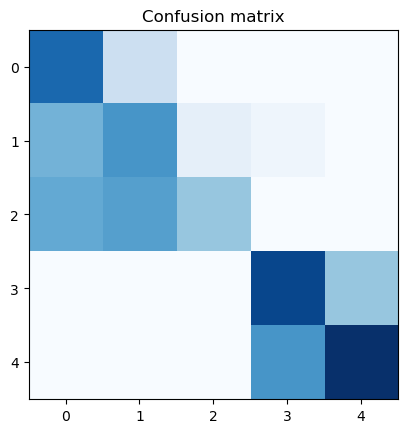

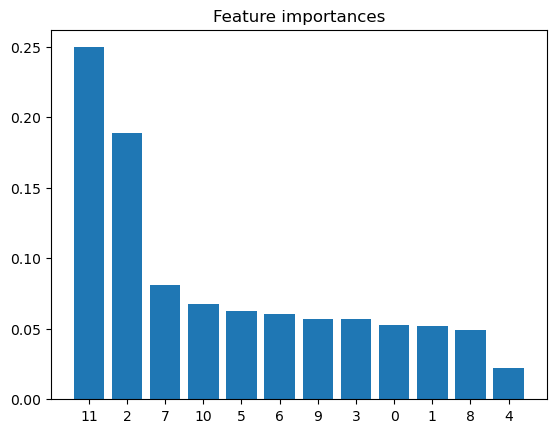

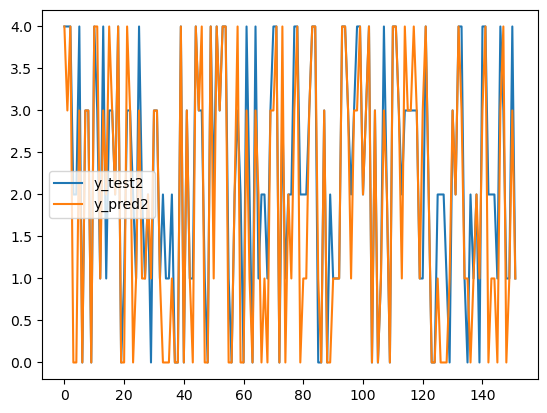

In [18]:

# Extract features from the data
import numpy as np
from scipy.integrate import cumtrapz

def fft_calculation(data, samplerate):
    data = data - np.mean(data)
    data = data / np.std(data)
    data = data * np.hanning(len(data))
    fft = np.abs(np.fft.fft(data))
    freqs = np.fft.fftfreq(len(data), d=1/samplerate)
    fft = fft[freqs >= 0]
    freqs = freqs[freqs >= 0]
    fft = fft[freqs <= 10]
    freqs = freqs[freqs <= 10]
    return np.max(fft)

def extract_features(recording):
    features = []

    #features.append(get_smart_watch_location(recording))
    

    cutoff_frequency = 0.8  # Cutoff frequency in Hz
    filter_order = 5  # The order of the filter
    # Filter the data
    ax = butter_lowpass_filter(recording.data['ax'].values, cutoff_frequency, recording.data['ax'].samplerate, filter_order)
    ay = butter_lowpass_filter(recording.data['ay'].values, cutoff_frequency, recording.data['ay'].samplerate, filter_order)
    az = butter_lowpass_filter(recording.data['az'].values, cutoff_frequency, recording.data['az'].samplerate, filter_order)
    gx = butter_lowpass_filter(recording.data['gx'].values, cutoff_frequency, recording.data['gx'].samplerate, filter_order)
    gy = butter_lowpass_filter(recording.data['gy'].values, cutoff_frequency, recording.data['gy'].samplerate, filter_order)
    gz = butter_lowpass_filter(recording.data['gz'].values, cutoff_frequency, recording.data['gz'].samplerate, filter_order)
    mx = butter_lowpass_filter(recording.data['mx'].values, cutoff_frequency, recording.data['mx'].samplerate, filter_order)
    my = butter_lowpass_filter(recording.data['my'].values, cutoff_frequency, recording.data['my'].samplerate, filter_order)
    mz = butter_lowpass_filter(recording.data['mz'].values, cutoff_frequency, recording.data['mz'].samplerate, filter_order)

    '''# normalize the data
    ax = normalize_min_max(ax)
    ay = normalize_min_max(ay)
    az = normalize_min_max(az)
    gx = normalize_min_max(gx)
    gy = normalize_min_max(gy)
    gz = normalize_min_max(gz)
    mx = normalize_min_max(mx)
    my = normalize_min_max(my)'''
    

    '''# watch location
    features.append(recording.labels['watch_loc'])'''

    # Mean of phone orientation data
    if 'phone_orientationx' in recording.data:

        features.append(np.mean(recording.data['phone_orientationx'].values))
    else:
        features.append(0)

    if 'phone_orientationy' in recording.data:
        features.append(np.mean(recording.data['phone_orientationy'].values))
    else:
        features.append(0)

    # Std of phone orientation data
    if 'phone_orientationx' in recording.data:
        features.append(np.std(recording.data['phone_orientationx'].values))
    else:
        features.append(0)
    
    if 'phone_orientationy' in recording.data:
        features.append(np.std(recording.data['phone_orientationy'].values))
    else:
        features.append(0)

   
    # FFT of ax data
    features.append(fft_calculation(ax, recording.data['ax'].samplerate))
    # FFT of ay data
    features.append(fft_calculation(ay, recording.data['ay'].samplerate))
    # FFT of gx data
    features.append(fft_calculation(gx, recording.data['gx'].samplerate))
    # FFT of gy data
    features.append(fft_calculation(gy, recording.data['gy'].samplerate))
    # FFT of mx data
    features.append(fft_calculation(mx, recording.data['mx'].samplerate))
    # FFT of my data
    features.append(fft_calculation(my, recording.data['my'].samplerate))
    # FFT of mz data
    features.append(fft_calculation(mz, recording.data['mz'].samplerate))



    # First 100 values of altitude minus Last 100 values of altitude

    if np.mean(recording.data['altitude'].values[1000:3000]) < np.mean(recording.data['altitude'].values[-3000:]):
        features.append(1)
    else:
        features.append(0)


    return features

# Normalize features
def normalize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)



# Extract features from all recordings
def extract_all_features(data):
    features = []
    for recording in data:
        features.append(extract_features(recording))
    return features



train_features2 = extract_all_features(all_train_data)
train_features2 = np.array(train_features2)
norm_train_features2 = normalize_features(train_features2)
norm_train_features2 = np.array(norm_train_features2)



y2 = []
for recording in all_train_data:
    y2.append(recording.labels['path_idx'])

# Split the data into training and testing data
X_train2, X_test2, y_train2, y_test2 = train_test_split(norm_train_features2, y2, test_size=0.2, random_state=42)

'''# Count labels in the training and testing data
unique, counts = np.unique(y_train, return_counts=True)
print(f"Training data Downhill: {dict(zip(unique, counts))}")
unique, counts = np.unique(y_test, return_counts=True)
print(f"Testing data Downhill: {dict(zip(unique, counts))}")

# Count labels in the training and testing data
unique, counts = np.unique(y_train2, return_counts=True)
print(f"Training data Uphill: {dict(zip(unique, counts))}")
unique, counts = np.unique(y_test2, return_counts=True)
print(f"Testing data Uphill: {dict(zip(unique, counts))}")'''


# Train a Random Forest Classifier with Cross Validation and Grid Search

# Define the classifier
clf = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [10, 15],
    'max_depth': [ 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform a grid search with cross validation and print training and test scores
grid_search = GridSearchCV(clf, param_grid, cv=2, n_jobs=-1, return_train_score=True)
grid_search.fit(X_train2, y_train2)

results = grid_search.cv_results_

# Print the mean training and testing scores for each parameter set
for i in range(len(results['params'])):
    print(f"Parameters: {results['params'][i]}")
    print(f"Mean Training Score: {results['mean_train_score'][i]:.3f}")
    print(f"Mean Test Score: {results['mean_test_score'][i]:.3f}")
    print('-' * 40)

# If you want to print scores for each individual fold as well
for i in range(len(results['params'])):
    for j in range(2):
        print(f"Parameters: {results['params'][i]} - Fold {j+1}")
        print(f"Training Score: {results[f'split{j}_train_score'][i]:.3f}")
        print(f"Test Score: {results[f'split{j}_test_score'][i]:.3f}")
    print('-' * 40)


# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Train the classifier with the best parameters
clf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
clf.fit(X_train2, y_train2)


# Predict the labels of the test data
y_pred2 = clf.predict(X_test2)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test2, y_pred2)
print(f"Accuracy: {accuracy}")

# Calculate balanced accuracy
balanced_accuracy = sklearn.metrics.balanced_accuracy_score(y_test2, y_pred2, adjusted=True)
print(f"Balanced Accuracy: {balanced_accuracy}")


# Plot the confusion matrix
cm = confusion_matrix(y_test2, y_pred2)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')

# plot features importance with name of the features
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train2.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train2.shape[1]), indices)
plt.xlim([-1, X_train2.shape[1]])
plt.show()

# plot y_test2 and y_pred2

plt.figure()
plt.plot(y_test2, label='y_test2')
plt.plot(y_pred2, label='y_pred2')
plt.legend()
plt.show()





